In [1]:
%matplotlib inline
import sys
from pyuvdata import UVData
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import itertools
import os
import scipy.signal
import scipy.stats
import xrfi_funcs

def running_median(x,N):
    idx = np.arange(N) + np.arange(len(x)-N+1)[:,None]
    arr=x[idx]
    out = np.median(arr[~np.isnan(arr)],axis=1)
    zeropad=list(np.zeros(N/2)) # this aligns the array again
    out = np.array(zeropad+list(out))
    return out
def nanZ(arr):
    return ((arr-np.nanmean(arr))/np.nanstd(arr))

def rolling_z(x, run_med_x, N, chan_min= None, chan_max = None):
    x[np.isnan(x)]=run_med_x[np.isnan(x)]
    idx = np.stack(np.arange(N) + np.arange(len(x)-N+1)[:,None] - N/2)%np.size(x)
    x2D = x[idx]
    x2D = np.stack( [  np.ma.array(x2D[row,:]).filled(np.median(x2D[row,:])) for row in np.arange(np.size(x2D,axis=0)) ] )
    run_med2D=run_med_x[idx]
    to_roll = np.array(run_med2D)
    to_roll[:,N/2] = x2D[:,N/2]
    rolling_z = np.stack([ nanZ(to_roll[row,:]) for row in np.arange(np.size(to_roll,axis=0))])
    
    # ignore zscore where the element's power = 0
    mask_z = np.zeros(np.shape(to_roll),dtype=bool)
    mask_z[:,N/2]=(to_roll[:,N/2] == 0.)
    rolling_z[mask_z]= 0.
    
    bool_print = ((chan_min is not None) and (chan_max is not None))
    if bool_print: 
        print('Rolling Z function, for chan_min: '+str(chan_min)+', chan_max: '+str(chan_max))
        print('    x: '+str(np.around(x[chan_min:chan_max],decimals=3)))
        print('    np.isnan(x)'+str(np.isnan(x[chan_min:chan_max])))
        print('    idx = '+str(idx[chan_min: chan_max,:]))
        print('    x2D'+str(np.around( x2D[chan_min: chan_max,:])))
        print('    run_med2D:'+str(np.around( run_med2D[chan_min: chan_max,:])))
        print('    x[idx] shape: '+str(np.shape(x2D)))
        print('    to_roll:'+str(np.around( to_roll[chan_min: chan_max,:])))
        print('    zscores: '+str(np.around(  rolling_z[chan_min:chan_max,:],decimals=2  )))
        print('    zscore shape: ' +str(np.shape(rolling_z) ) )
        print('    returning z scores: '+str(np.around(np.array(rolling_z[:,N/2])[chan_min:chan_max],decimals=2)))

    return rolling_z[:,N/2]

def find_nearest_val(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# load data here.
#str_dir = '/Users/josaitis/RFI_Analysis_7May/files/'
#str_dir = '/lustre/aoc/projects/hera/ajosaiti/May_7_night_11dot6/2458611/'
str_dir = '/lustre/aoc/projects/hera/H1C_IDR2/IDR2_2/2458098/'

items = os.listdir(str_dir)

uvfiles = []
for names in items:
    if names.endswith(".HH.uvh5"):
        uvfiles.append(names)

print('Files to process, in dir '+str_dir+': '+str(sorted(uvfiles)))
uvfiles = sorted([str_dir + s  for s in uvfiles])


uvd = UVData()
uvd.read(uvfiles,antenna_nums=[12,13], axis='blt')

Files to process, in dir /lustre/aoc/projects/hera/H1C_IDR2/IDR2_2/2458098/: ['zen.2458098.12552.HH.uvh5', 'zen.2458098.13298.HH.uvh5', 'zen.2458098.14043.HH.uvh5', 'zen.2458098.14789.HH.uvh5', 'zen.2458098.15535.HH.uvh5', 'zen.2458098.16280.HH.uvh5', 'zen.2458098.17026.HH.uvh5', 'zen.2458098.17772.HH.uvh5', 'zen.2458098.18517.HH.uvh5', 'zen.2458098.19263.HH.uvh5', 'zen.2458098.20008.HH.uvh5', 'zen.2458098.20754.HH.uvh5', 'zen.2458098.21500.HH.uvh5', 'zen.2458098.22245.HH.uvh5', 'zen.2458098.22991.HH.uvh5', 'zen.2458098.23737.HH.uvh5', 'zen.2458098.24482.HH.uvh5', 'zen.2458098.25228.HH.uvh5', 'zen.2458098.25974.HH.uvh5', 'zen.2458098.26719.HH.uvh5', 'zen.2458098.27465.HH.uvh5', 'zen.2458098.28211.HH.uvh5', 'zen.2458098.28956.HH.uvh5', 'zen.2458098.29702.HH.uvh5', 'zen.2458098.30448.HH.uvh5', 'zen.2458098.31193.HH.uvh5', 'zen.2458098.31939.HH.uvh5', 'zen.2458098.32685.HH.uvh5', 'zen.2458098.33430.HH.uvh5', 'zen.2458098.34176.HH.uvh5', 'zen.2458098.34922.HH.uvh5', 'zen.2458098.35667.HH.u

# Metadata Output

In [2]:
# your answers here (hint: look at the attributes of your uvd object)

print 'There are', len(uvd.antenna_numbers), 'antennas and they are:', uvd.antenna_numbers

print 'There are', uvd.Nbls, 'baselines, which corresponds to N(N-1)/2 cross-correlations plus N auto-correlations.'

print 'There are', uvd.Nfreqs, 'frequencies, covering a range of', \
    np.min(uvd.freq_array)/1e6, 'MHz to',np.max(uvd.freq_array)/1e6,'MHz.'

print 'The width of each frequency channel is', (np.max(uvd.freq_array)-np.min(uvd.freq_array))/uvd.Nfreqs/1e6, 'MHz'

print 'There are', uvd.Ntimes, 'time integrations.'

print 'The LSTs are', np.unique(uvd.lst_array)*12/np.pi, 'in hours.'

There are 52 antennas and they are: [136 140 121  88  41  86  36  51  50  98 123 124  65 137  82 120 143  66
  83 122  67  68  69  70  71  85   0   1  11  12  13  14   2  23  24  25
  26  27  37  38  39  40  52  53  54  55  84  87 141 138 142 139]
There are 3 baselines, which corresponds to N(N-1)/2 cross-correlations plus N auto-correlations.
There are 1024 frequencies, covering a range of 100.0 MHz to 199.90234375 MHz.
The width of each frequency channel is 0.09756088256835938 MHz
There are 4354 time integrations.
The LSTs are [2.51805045e-03 5.50883284e-03 8.49961524e-03 1.14903976e-02
 1.44811800e-02 1.74719624e-02 2.04627448e-02 2.34535272e-02
 2.64442984e-02 2.94350808e-02 3.24258632e-02 3.54166456e-02
 3.84074280e-02 4.13982104e-02 4.43889928e-02 4.73797752e-02
 5.03705576e-02 5.33613400e-02 5.63521223e-02 5.93429047e-02
 6.23336871e-02 6.53244695e-02 6.83152519e-02 7.13060343e-02
 7.42968167e-02 7.72875991e-02 8.02783815e-02 8.32691639e-02
 8.62599463e-02 8.92507287e-02 9.22415

# Visualizing the Array

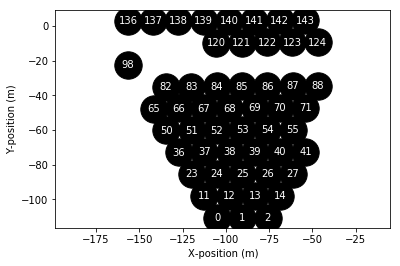

In [3]:
import matplotlib.pyplot as plt
#%matplotlib notebook

antpos, ants = uvd.get_ENU_antpos() # this returns coordinates of each antenna and a list of the antennas

plt.figure()
plt.scatter(antpos[:,0], antpos[:,1], marker='.', color='k', s=3000) # plot the antenna positions with black circles
for aa,ant in enumerate(ants): # loop over antennas
    plt.text(antpos[aa,0], antpos[aa,1], ants[aa], color='w', va='center', ha='center') # label antenna numbers
plt.xlabel('X-position (m)')
plt.ylabel('Y-position (m)')
plt.axis('equal');

# Pre-XRFI Waterfalls

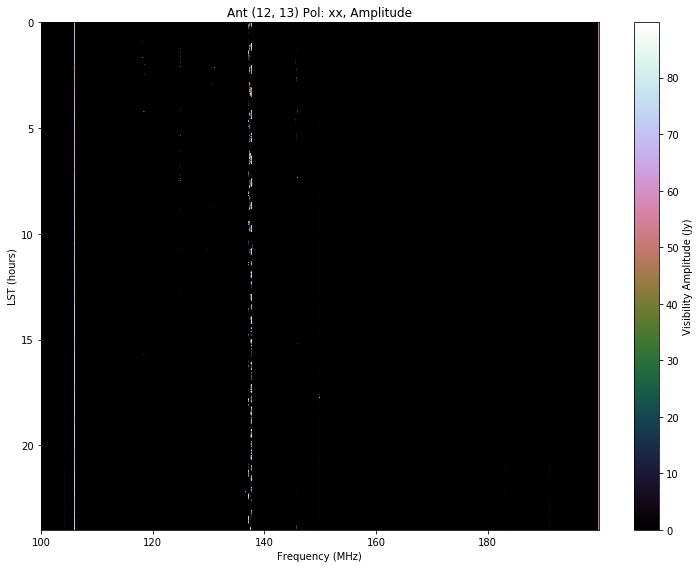

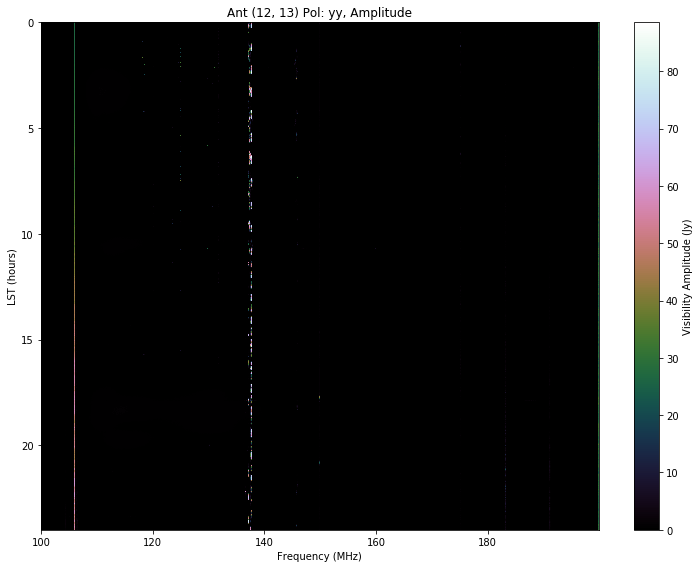

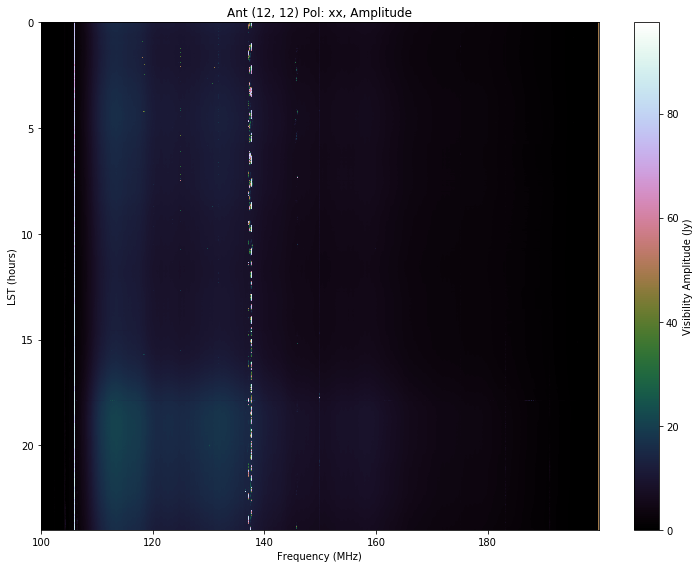

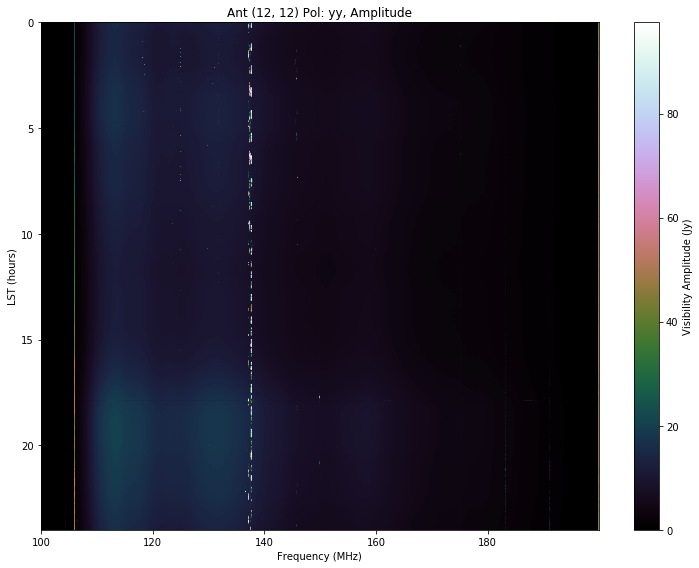

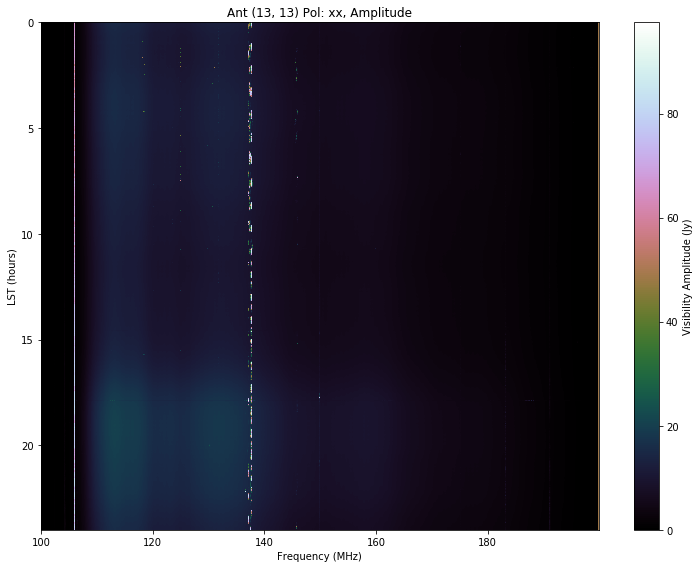

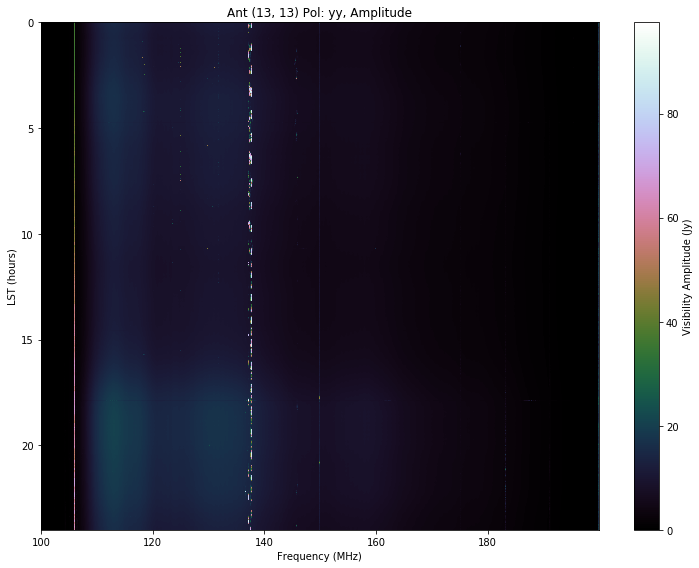

In [4]:
ants_select = np.array([12,13])
ant_combination = np.array( list( itertools.combinations(ants_select, 2) ) )
for ant in ants_select:
    ant_combination= np.append(ant_combination, [[ant,ant]], axis=0)
    
np.shape(ant_combination)

ii=0
while ii < np.size(ant_combination[:,0]):
    pols = np.array(['xx','yy'])
    for pol in pols:
        key=(ant_combination[ii,0],ant_combination[ii,1],str(pol))
        vis=uvd.get_data(key)
        plt.figure(figsize=(20,8))
        
        plt.subplot(121) #For amplitude
        plt.imshow(np.abs(vis), aspect='auto',cmap='cubehelix',extent=(np.min(uvd.freq_array[0])/1e6,np.max(uvd.freq_array[0])/1e6,np.max(np.unique(uvd.lst_array))*12/np.pi,np.min(np.unique(uvd.lst_array))*12/np.pi))
        plt.colorbar(label='Visibility Amplitude (Jy)')
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('LST (hours)')
        plt.title('Ant ('+str(ant_combination[ii,0])+', '+str(ant_combination[ii,1])+') Pol: '+str(pol)+', Amplitude')

        plt.tight_layout();
    ii = ii+1

# Single Antenna Analysis

In [5]:
#Fixed parameters
Nmed=7
arr_str_run = np.array(['Raw', 'Round 1', 'Round 2'])
figx=30;figy=30; 
xticks=np.linspace(np.min(uvd.freq_array[0])/1e6,np.max(np.array(uvd.freq_array[0]/1.e6)[1:]),50);
ymin=0.95;ymax=1.05
rolling_Z_thresh = 2.25
N_rolling_Z = 11
key=(12,12,'xx')
vis=uvd.get_data(key)
chan_min = (np.abs(uvd.freq_array[0]/1e6 - 120.)).argmin()
chan_max= (np.abs(uvd.freq_array[0]/1e6 - 140.)).argmin()

Begin analysis, creating arrays...
Finished creating arrays. 
Entering loop for Raw data.
Entering loop for Round 1 data.
Calculating XRFI data...


divide by zero encountered in divide
invalid value encountered in divide
invalid value encountered in greater
invalid value encountered in greater


Calculating rolling Z-score data...


Calculating visibility data...
Plotting...


Casting complex values to real discards the imaginary part


End round 1.
Entering loop for Round 2 data.
Calculating XRFI data...
Calculating rolling Z-score data...
Calculating visibility data...
Plotting...


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


End round 2.


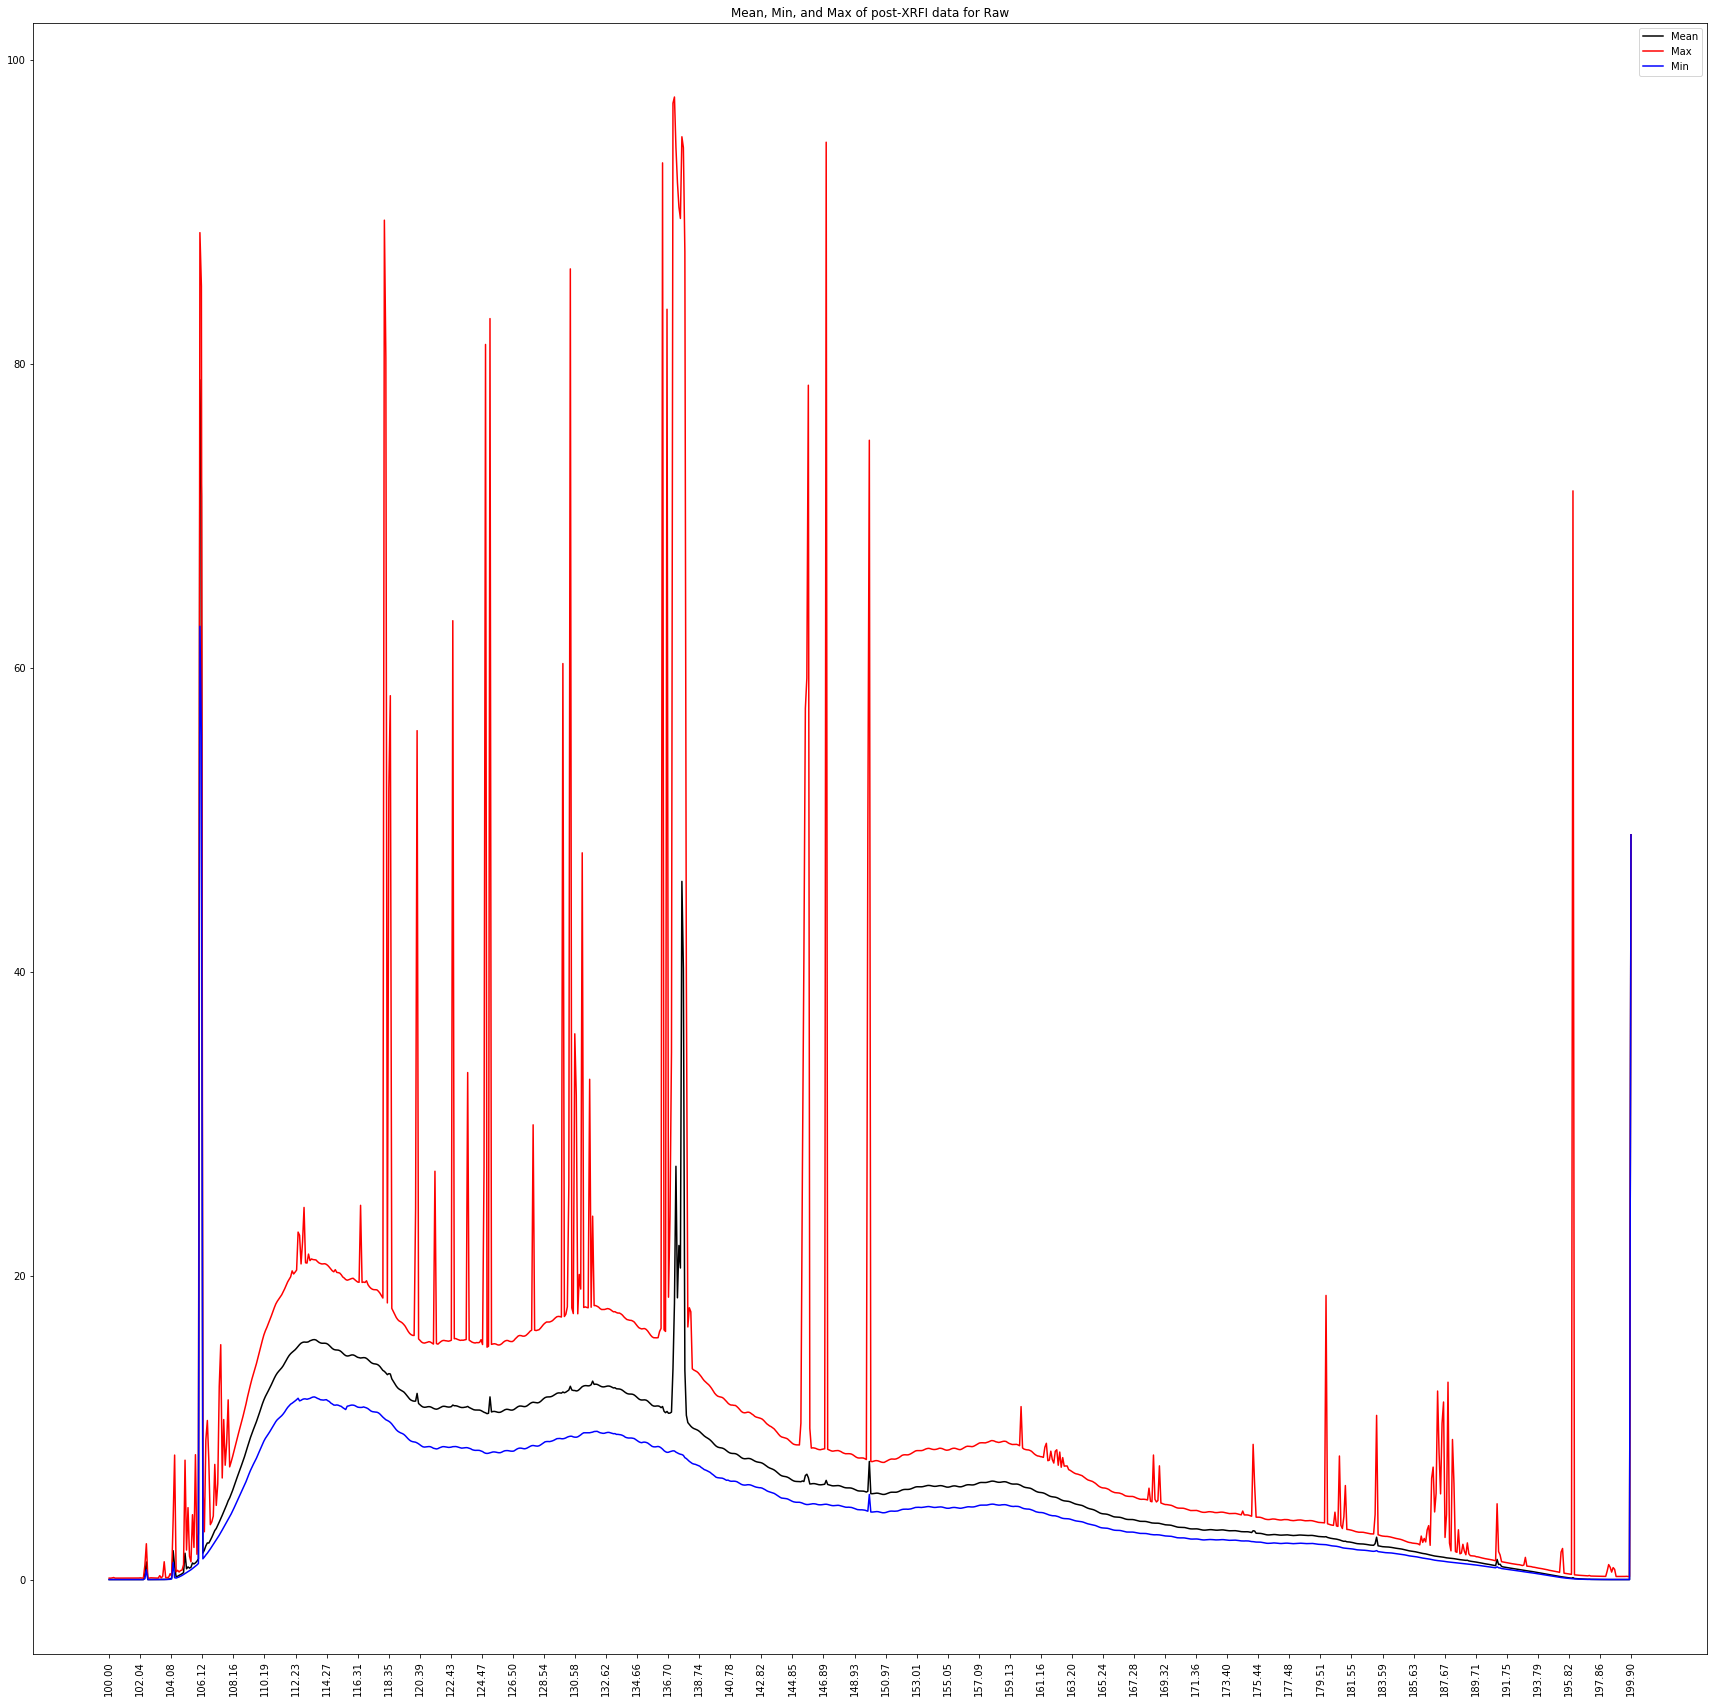

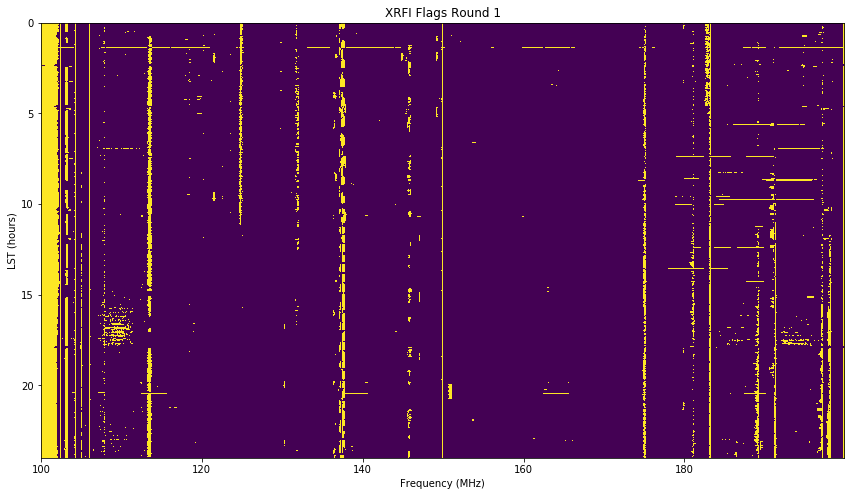

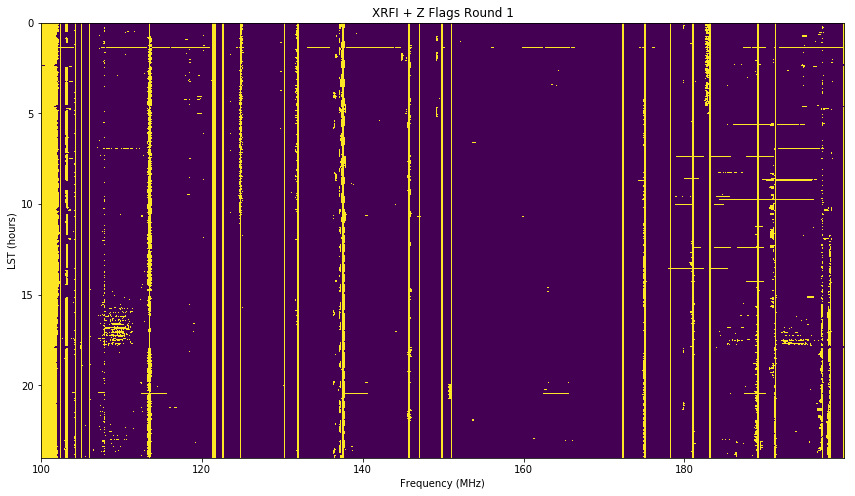

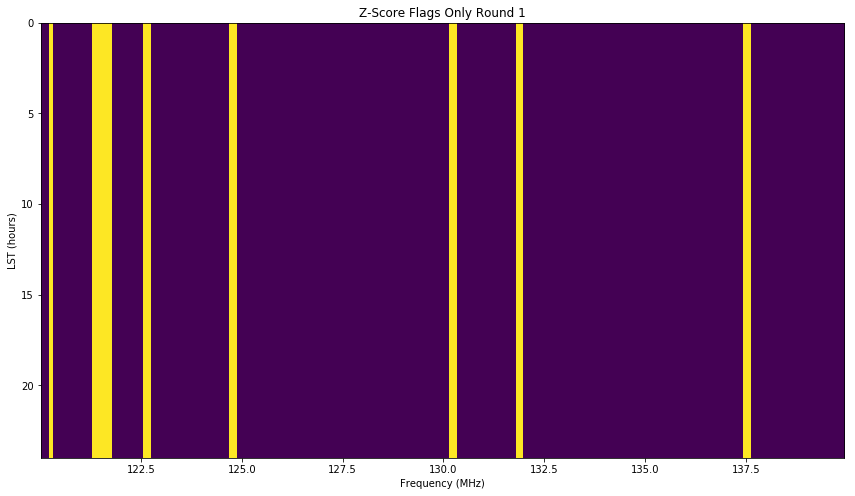

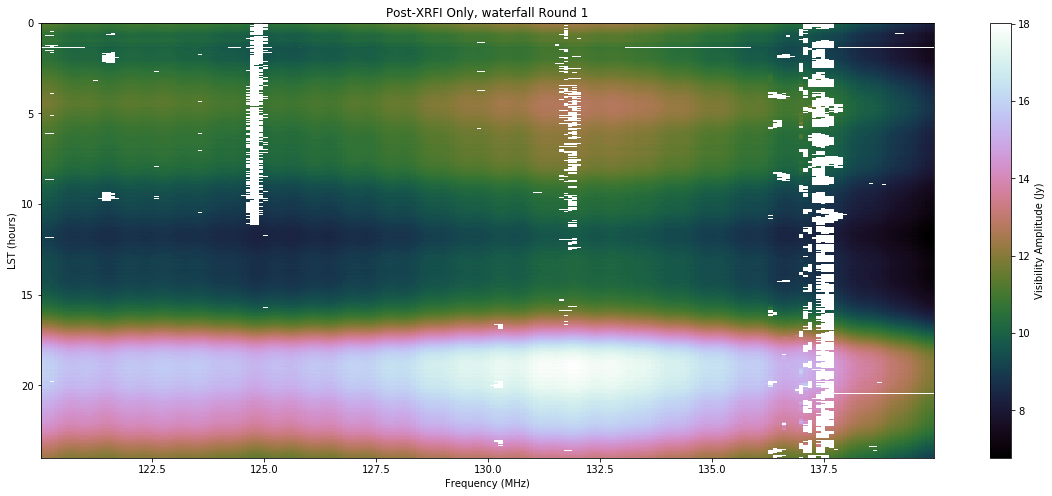

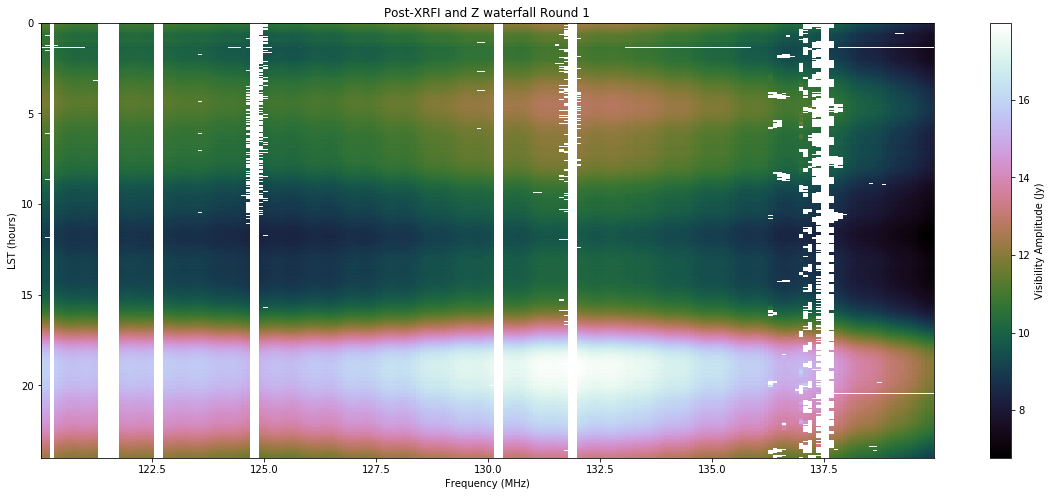

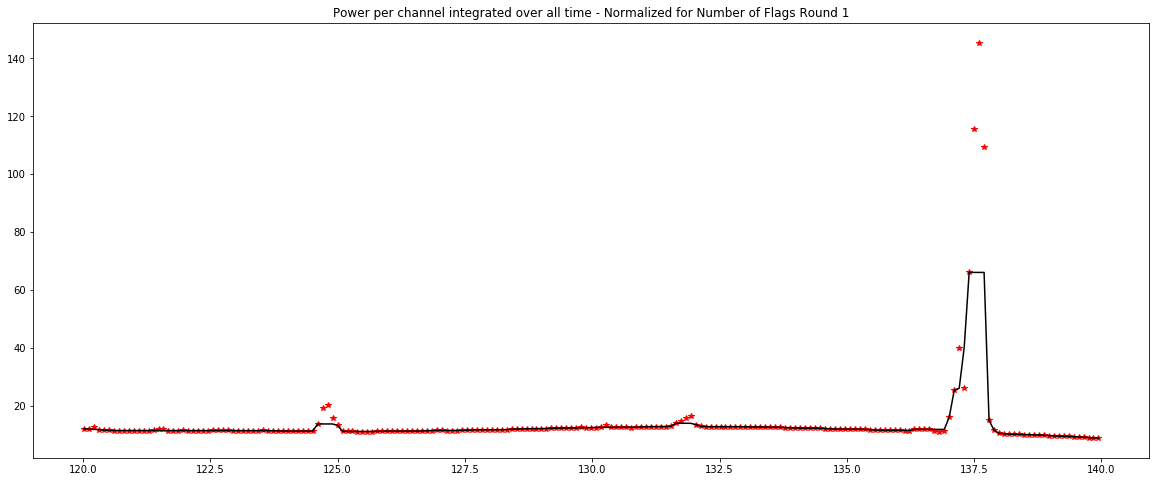

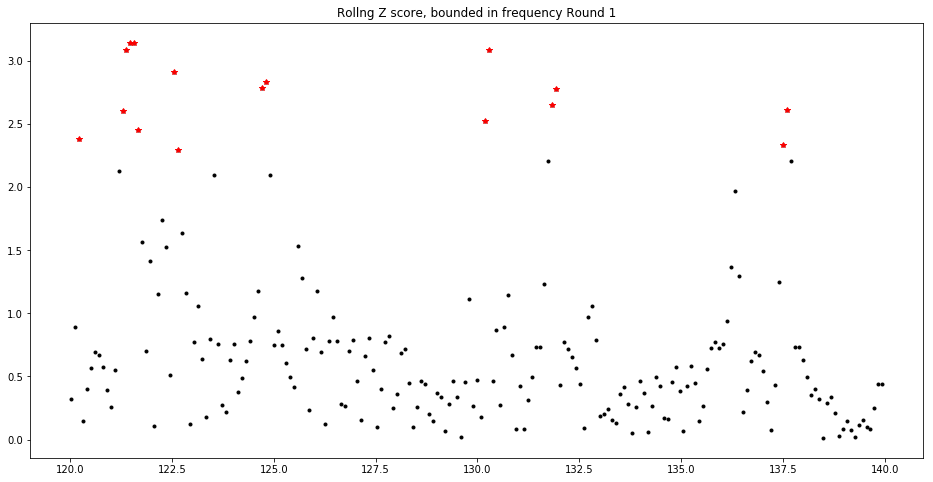

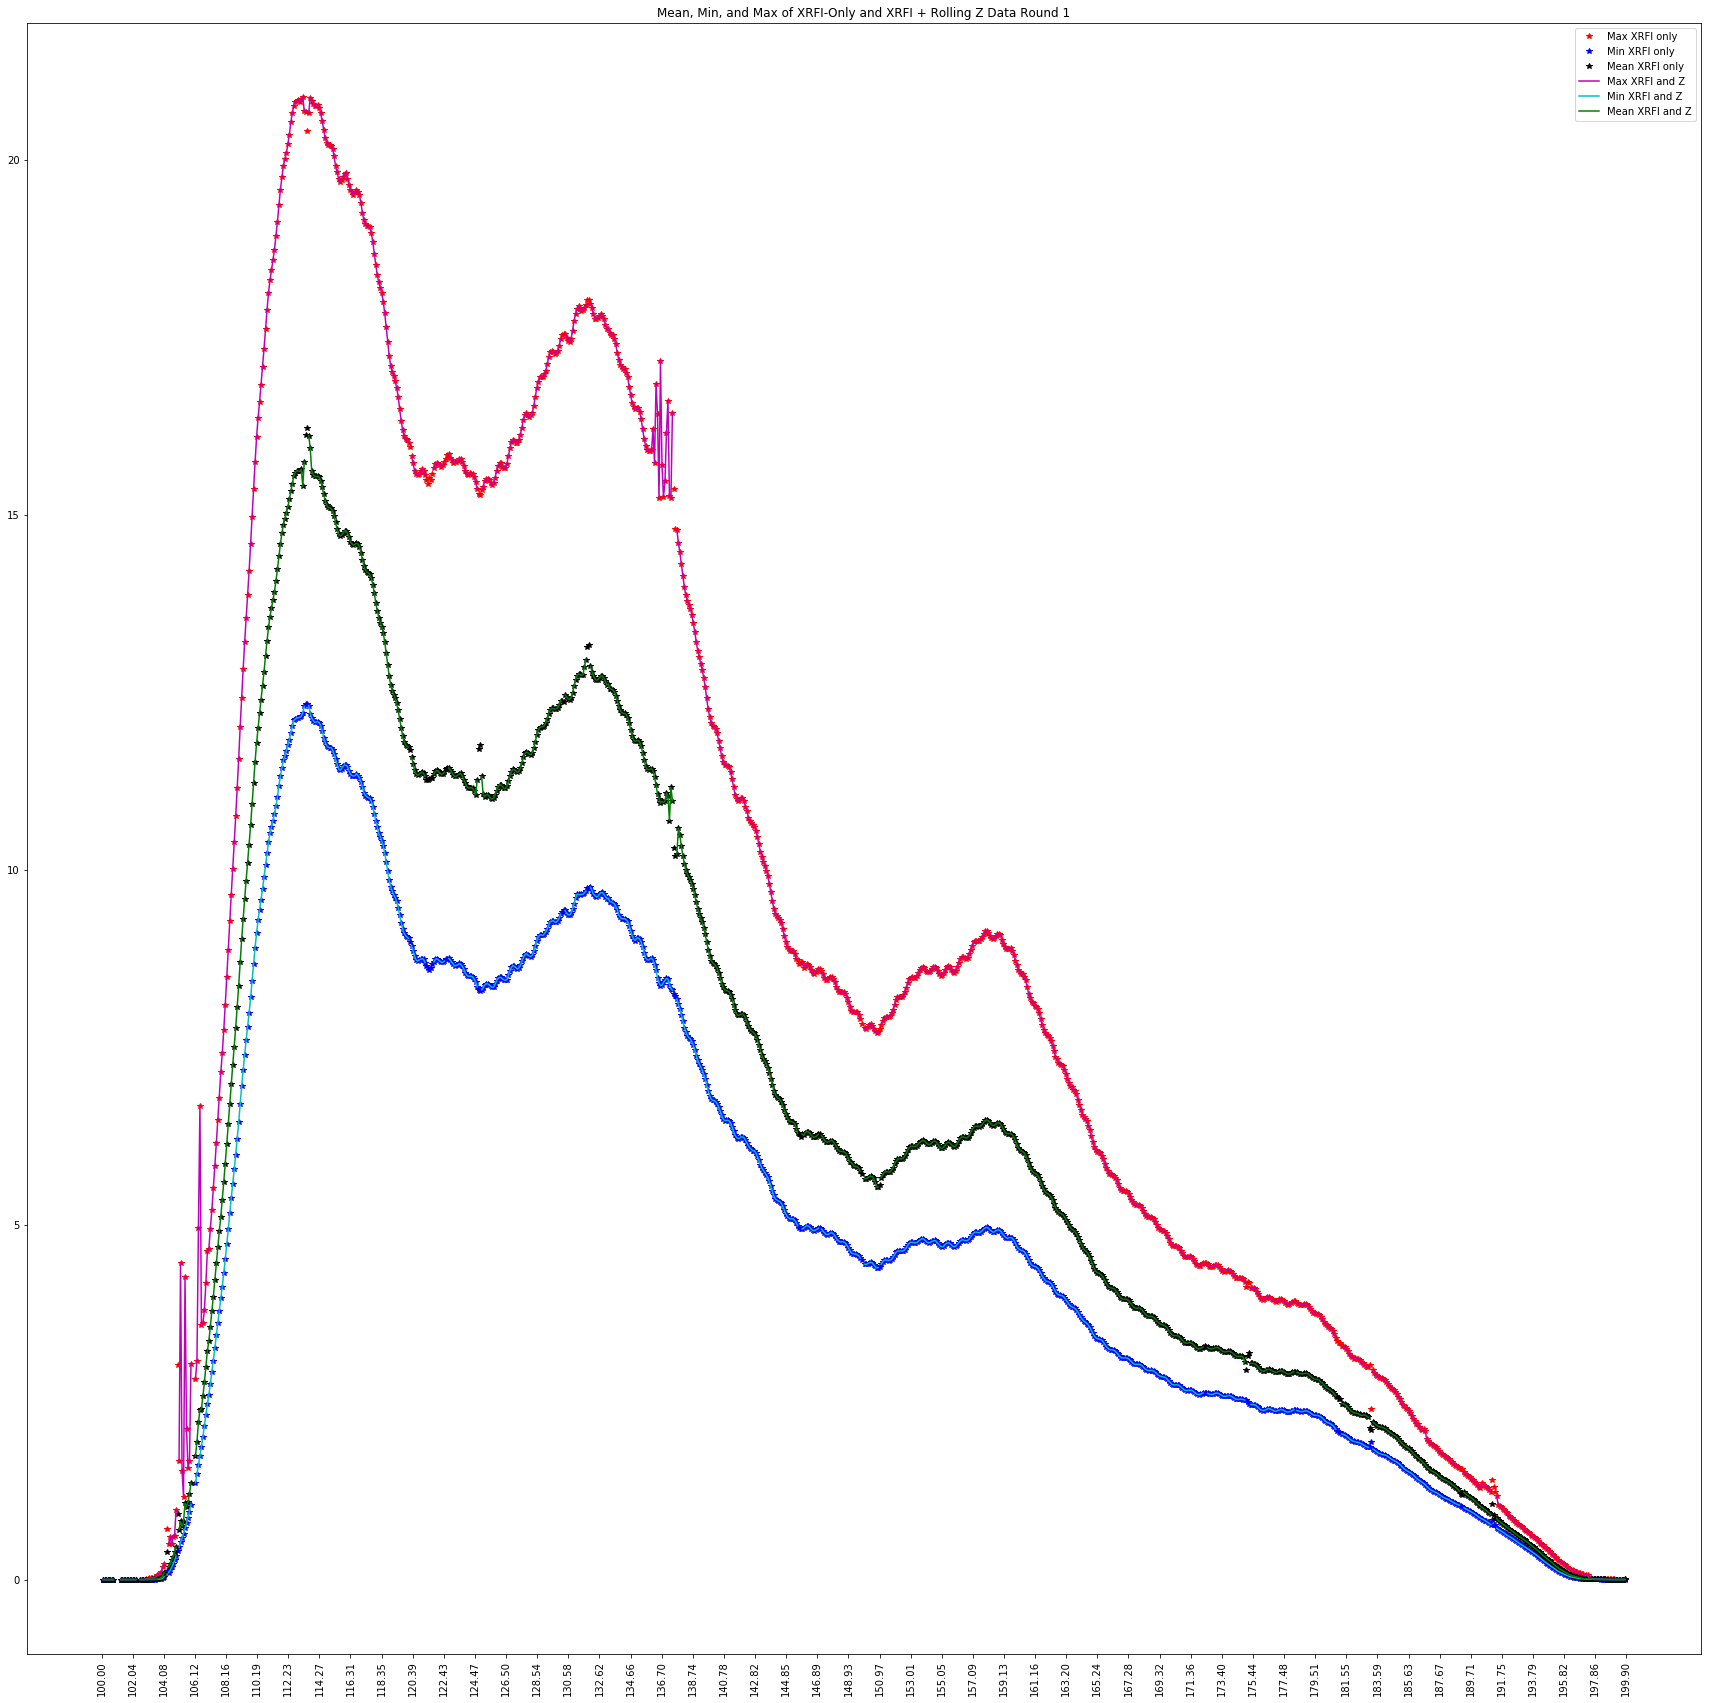

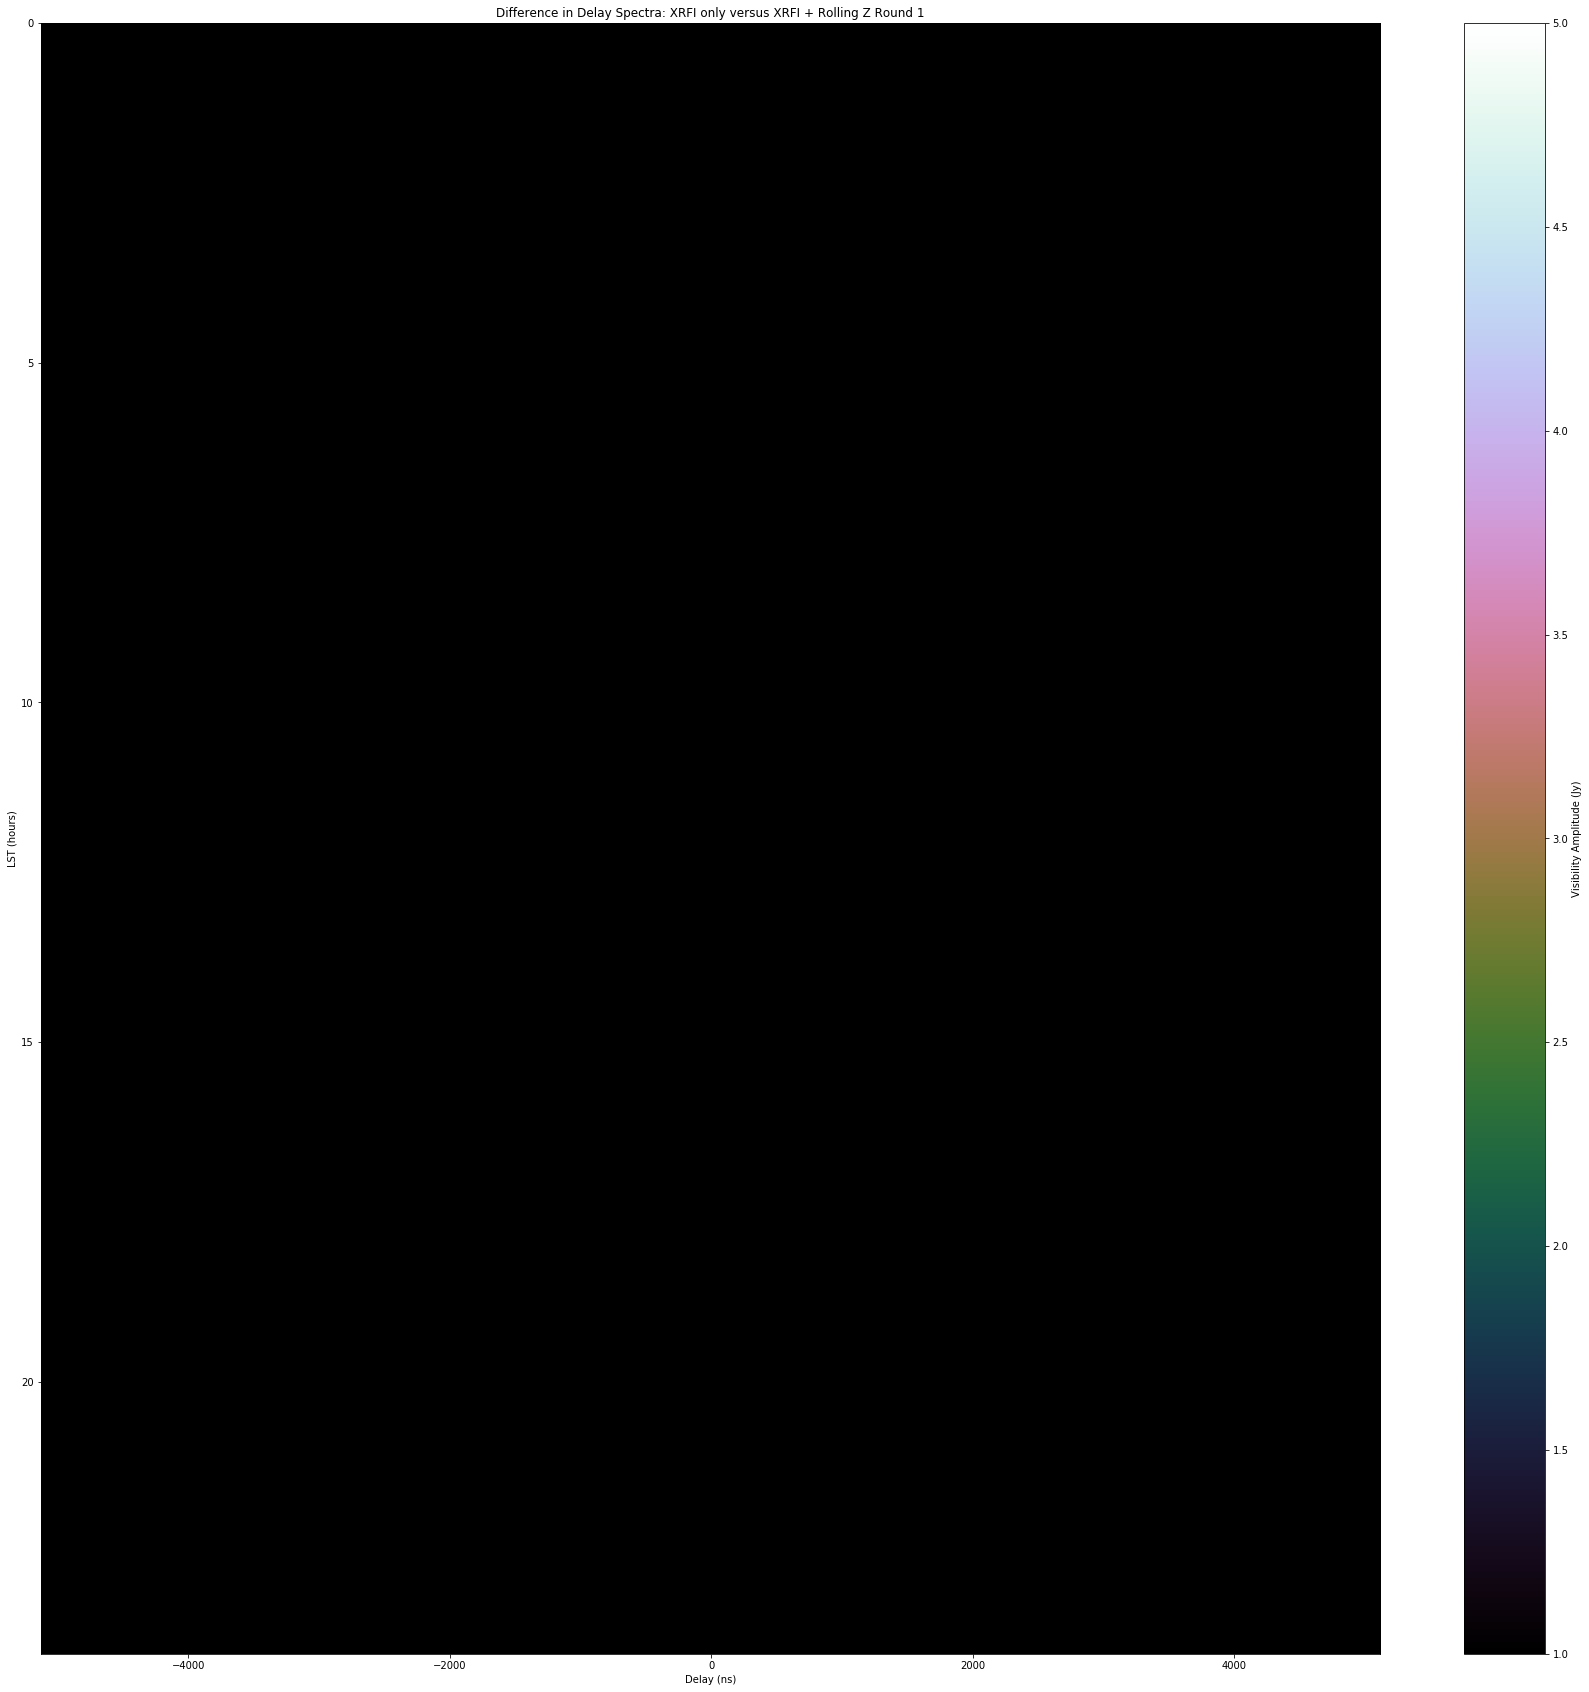

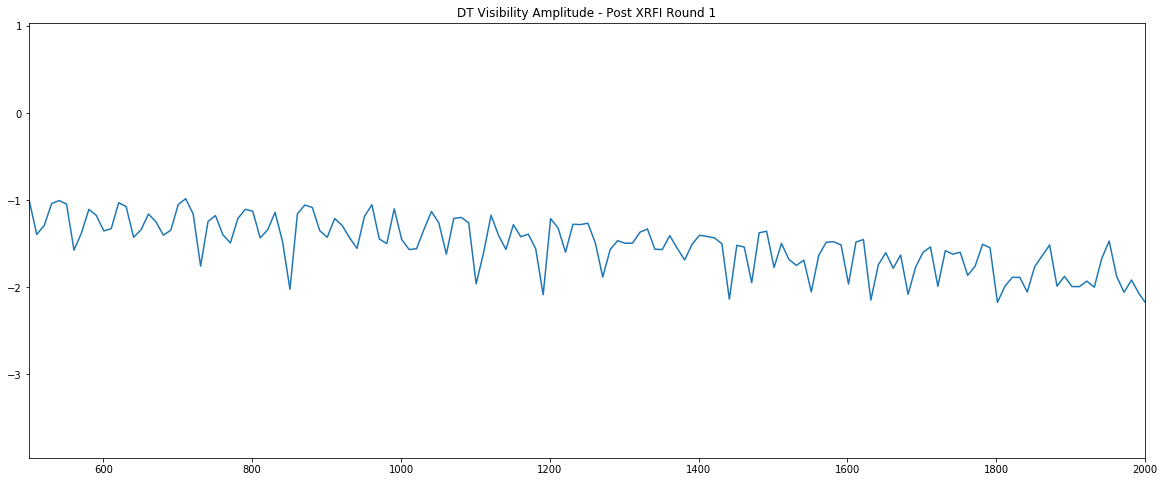

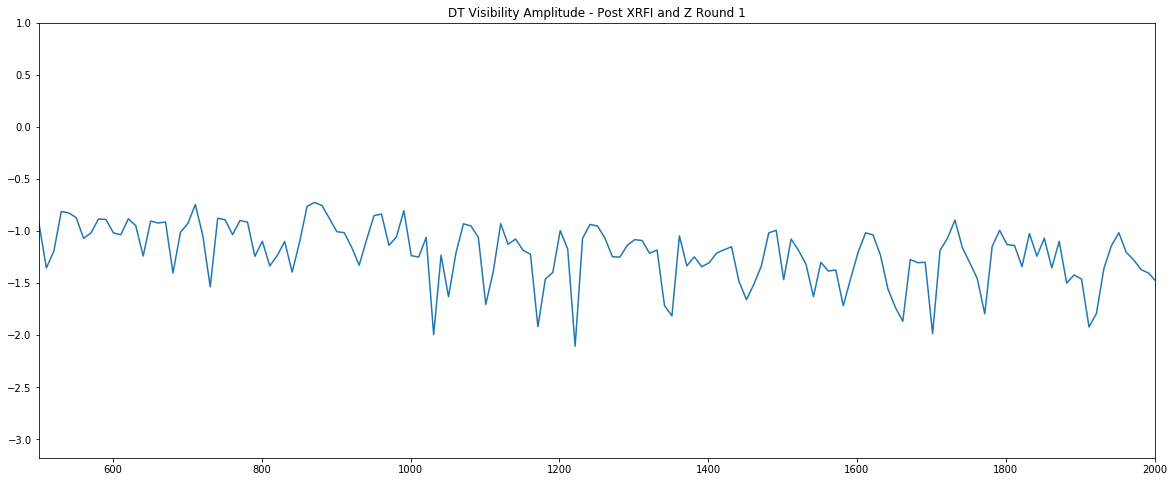

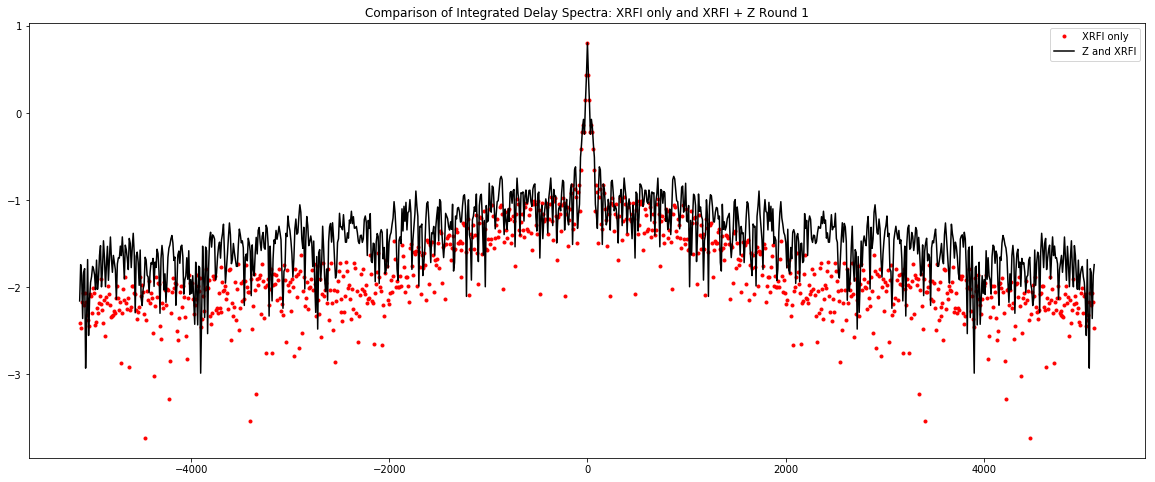

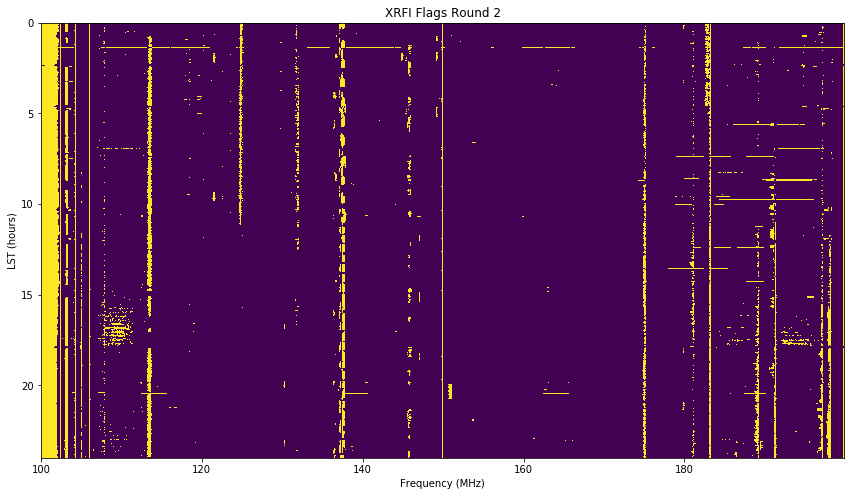

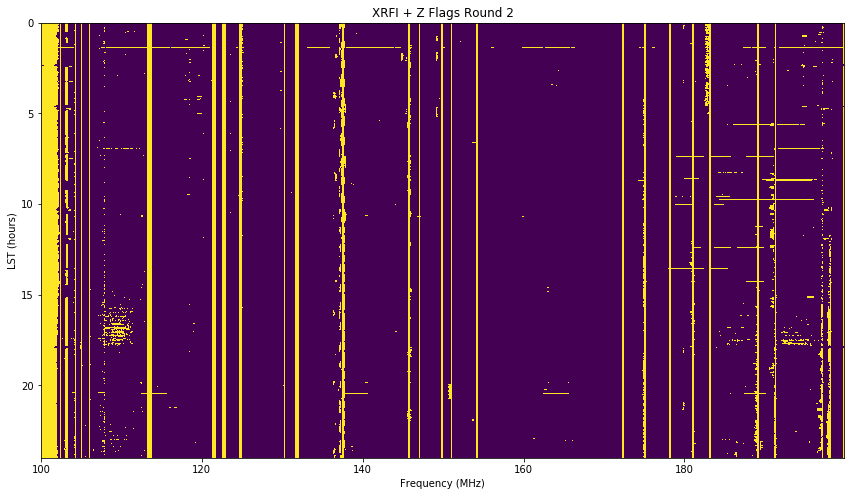

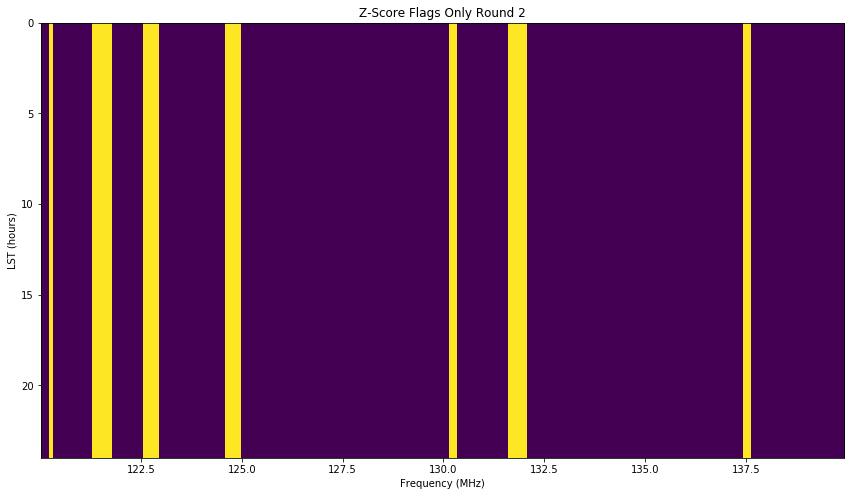

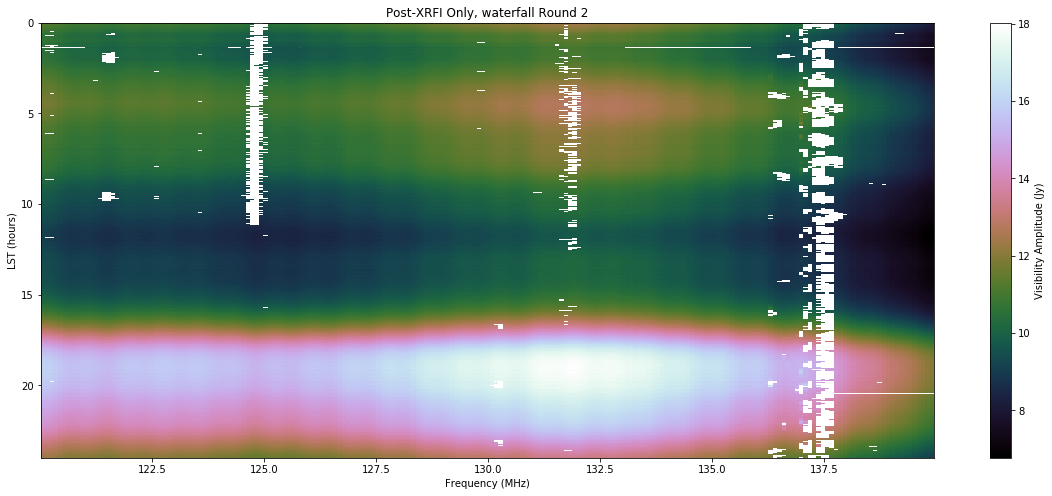

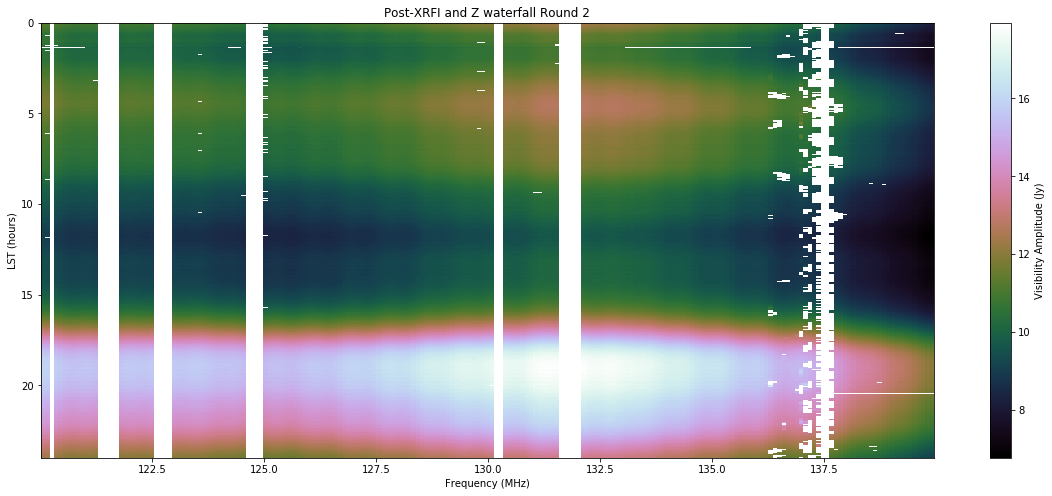

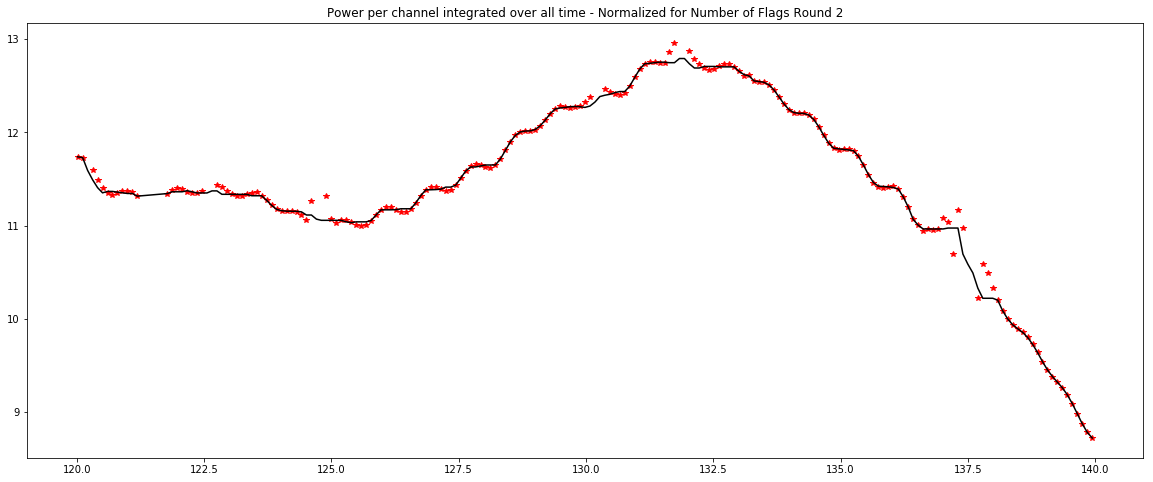

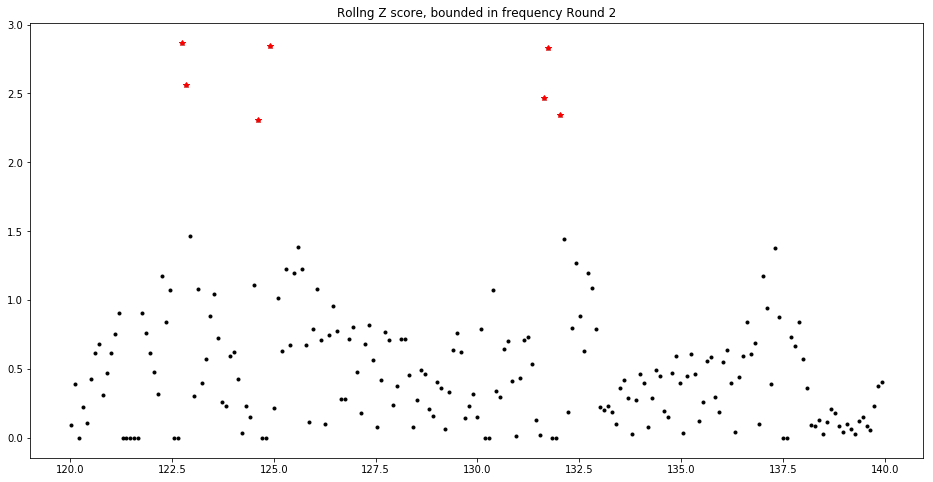

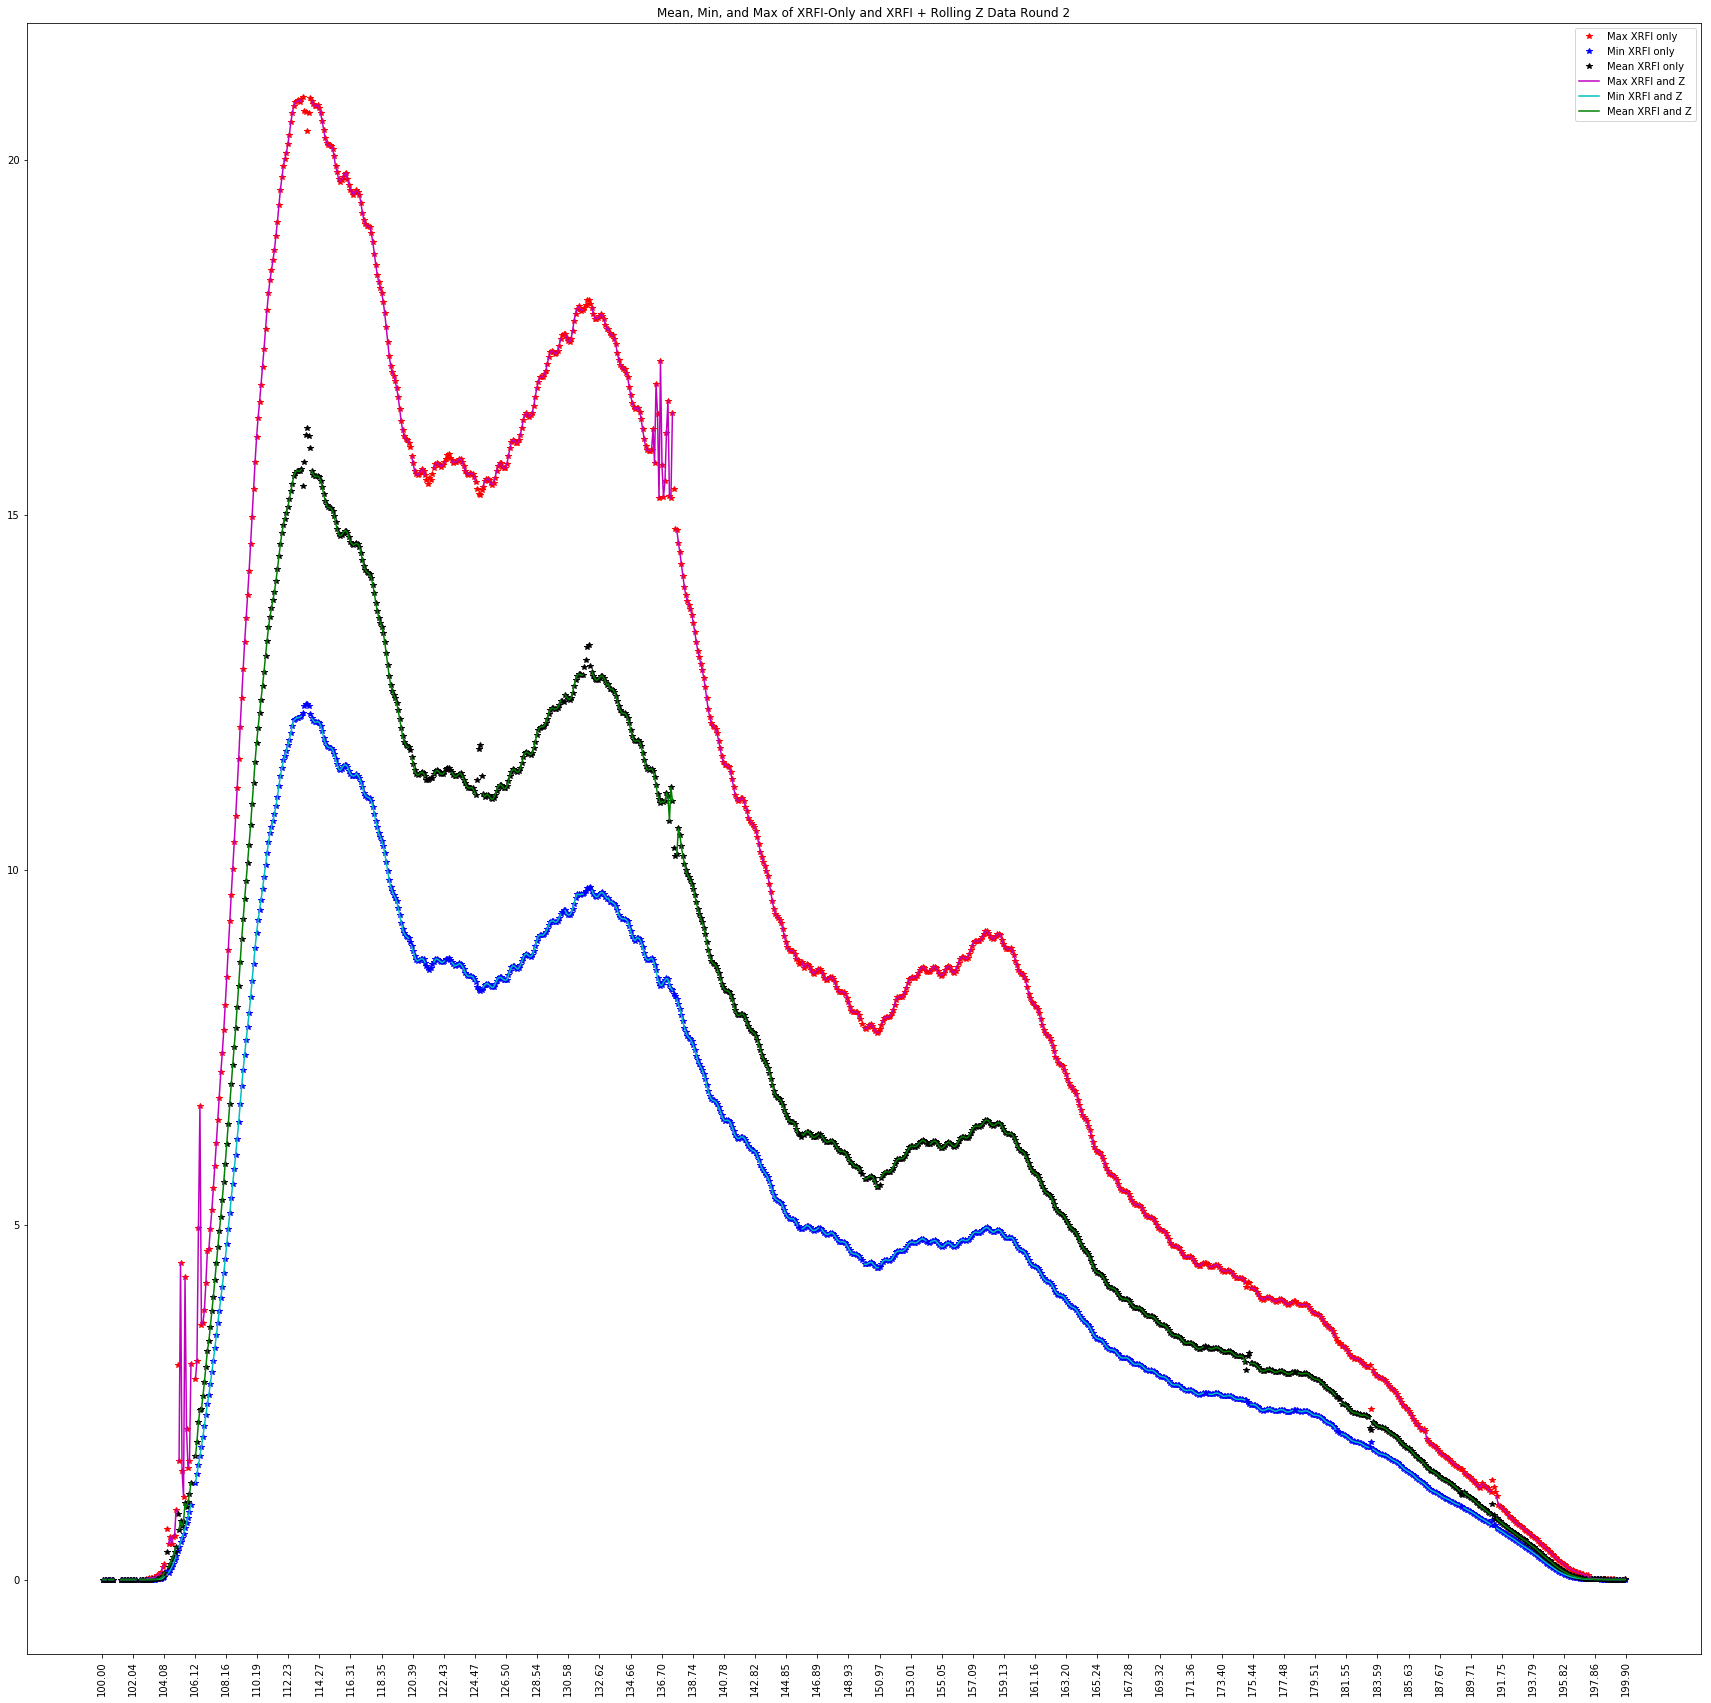

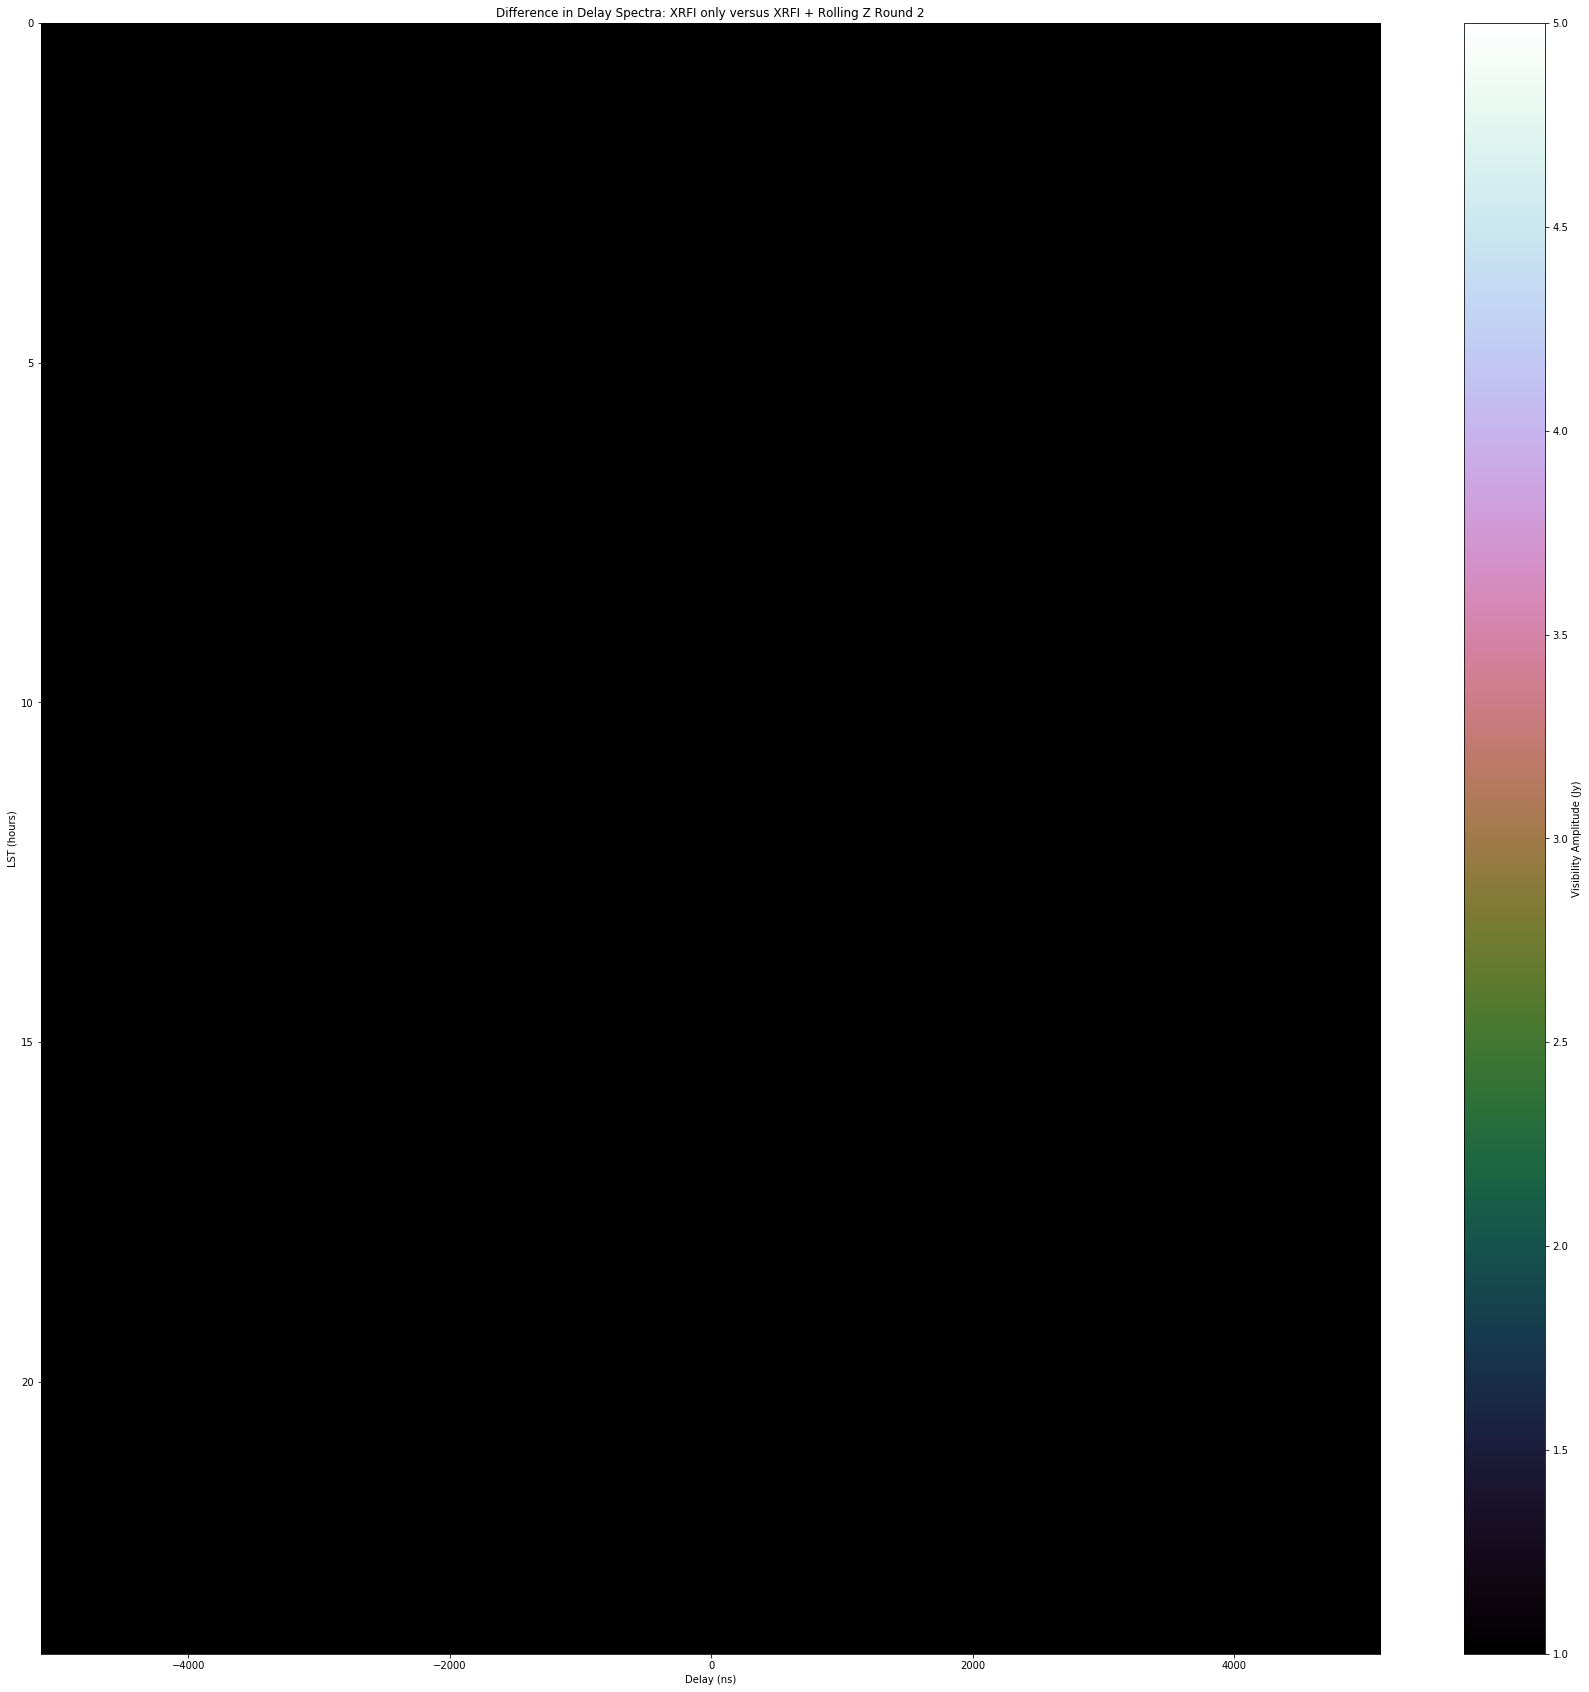

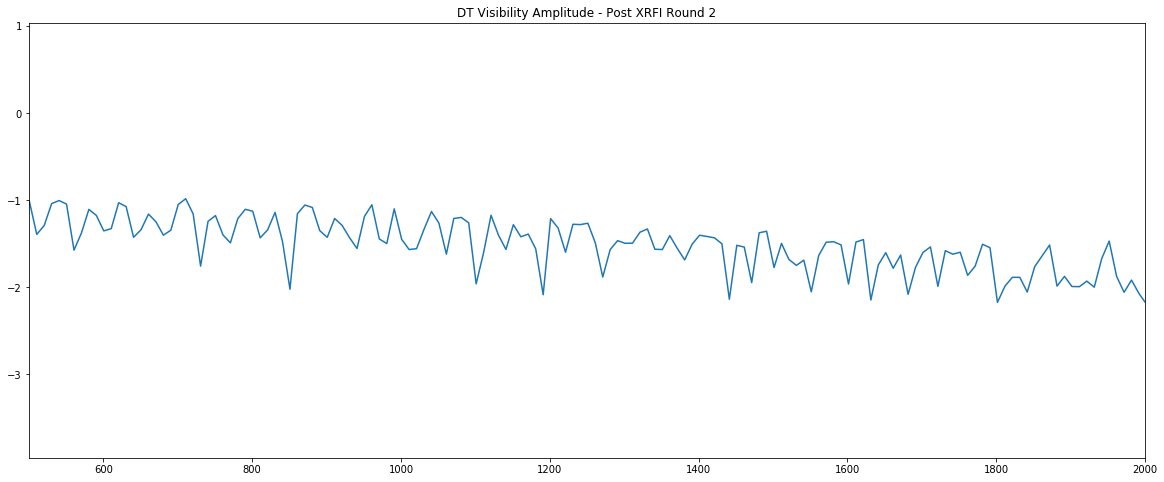

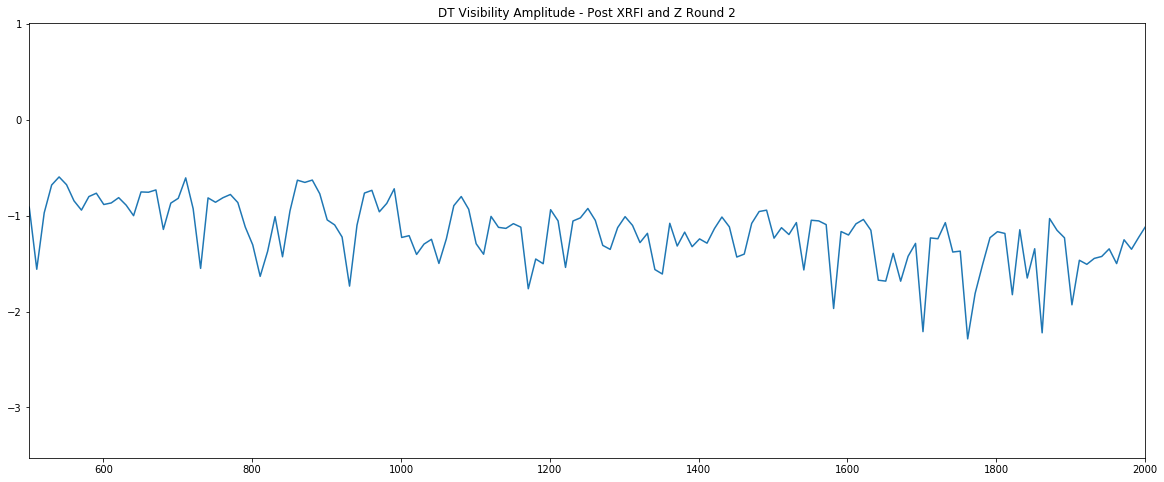

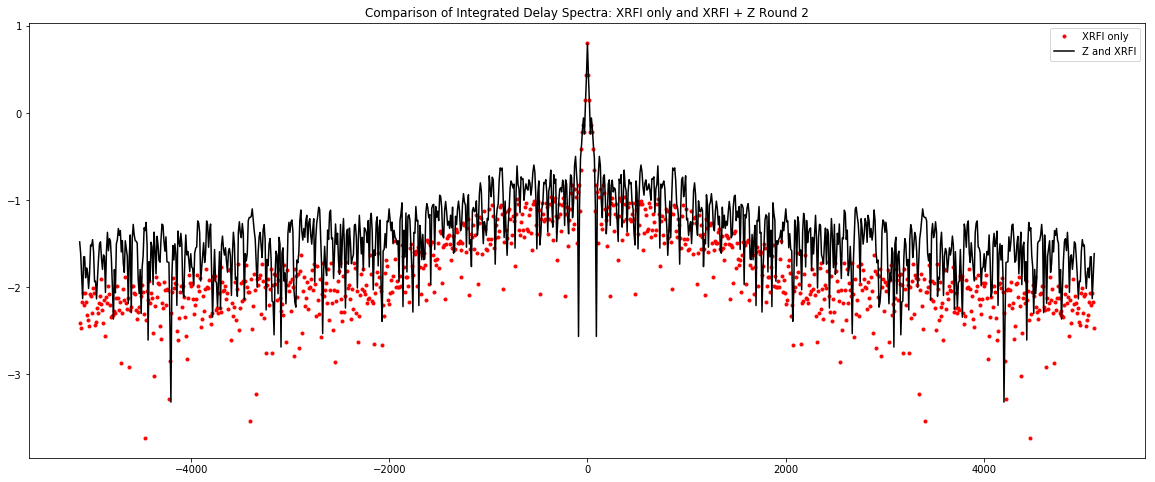

In [6]:
irun = 0; Nruns =3;
print('Begin analysis, creating arrays...')
powers_per_time = np.abs(vis)
powers_per_time_XRFI =powers_per_time #np.zeros((uvd.Ntimes,uvd.Nfreqs))
powers_per_time_XRFI_and_Z = powers_per_time#np.zeros((uvd.Ntimes,uvd.Nfreqs))
mask_XRFI = np.zeros((uvd.Ntimes,uvd.Nfreqs), dtype=bool)
mask_Z_and_XRFI = np.zeros((uvd.Ntimes,uvd.Nfreqs), dtype=bool)
mask_Zscore = np.zeros((uvd.Ntimes,uvd.Nfreqs), dtype=bool)
print('Finished creating arrays. ')

while irun < Nruns:
    print('Entering loop for '+arr_str_run[irun]+' data.')
    #calculate all for this round
    arr_mean = np.mean(powers_per_time,axis=0)
    arr_max = np.max(powers_per_time,axis=0)
    arr_min = np.min(powers_per_time,axis=0)
    
    if irun == 0:
        plt.figure(figsize=(figx,figy))
        plt.plot( np.array(uvd.freq_array[0]/1.e6), arr_mean,'k-',label='Mean')
        plt.plot( np.array(uvd.freq_array[0]/1.e6), arr_max,'r-',label='Max')
        plt.plot( np.array(uvd.freq_array[0]/1.e6), arr_min,'b-',label='Min')
        plt.title('Mean, Min, and Max of post-XRFI data for '+arr_str_run[irun])
        plt.legend()
        plt.xticks(xticks,rotation='vertical')
    
    #calculations of things XRFI and Rolling Z
    if irun >=1:
        ### CALCULATIONS ###
        #XRFI calculations
        print('Calculating XRFI data...')
        mask_XRFI = np.logical_or(mask_XRFI, xrfi_funcs.xrfi(powers_per_time_XRFI))
        powers_per_time_XRFI=np.ma.array(powers_per_time_XRFI,mask=mask_XRFI)
        mean_XRFI = np.mean(powers_per_time_XRFI,axis=0)
        max_XRFI = np.max(powers_per_time_XRFI,axis=0)
        min_XRFI = np.min(powers_per_time_XRFI,axis=0)
        
        #Rolling Z-score calculations
        print('Calculating rolling Z-score data...')
        int_P_dt = np.ma.sum(powers_per_time_XRFI_and_Z,axis=0)/(np.size(powers_per_time_XRFI_and_Z[:,0])-np.sum(mask_XRFI,axis=0))
        running_med_Pt= scipy.signal.medfilt(int_P_dt,Nmed)
        #scipy.stats.zscore(int_P_dt)
        arr_rolling_z = rolling_z(int_P_dt,running_med_Pt,N_rolling_Z)#,chan_min,chan_max)
        idx_bad = np.argwhere(np.abs(arr_rolling_z)>rolling_Z_thresh)
        mask_Zscore[:,idx_bad] = True
        mask_Z_and_XRFI = np.logical_or(mask_Z_and_XRFI,np.logical_or(mask_Zscore, mask_XRFI))
        powers_per_time_XRFI_and_Z= np.ma.masked_array(powers_per_time_XRFI_and_Z,mask=mask_Z_and_XRFI)
        mean_XRFI_plus_Z = np.mean(powers_per_time_XRFI_and_Z,axis=0)
        max_XRFI_plus_Z = np.max(powers_per_time_XRFI_and_Z,axis=0)
        min_XRFI_plus_Z = np.min(powers_per_time_XRFI_and_Z,axis=0)
        
        
        #Calculate visibilites
        print('Calculating visibility data...')
        vis=vis/np.size(vis,axis=1) #normalize
        vis_dt = np.fft.fftshift(np.fft.fft(vis,axis=1),axes=1) # Fourier-transform along frequency
        vis_XRFI = uvd.get_data(key)*~mask_XRFI
        vis_XRFI = vis_XRFI / ( np.size(mask_XRFI,axis=1)-np.sum(mask_XRFI,axis=1)[:,None]) #normalize
        vis_dt_XRFI= np.fft.fftshift(np.fft.fft(vis_XRFI,axis=1),axes=1)
        vis_Z_and_XRFI = uvd.get_data(key)*~mask_Z_and_XRFI
        vis_Z_and_XRFI = vis_Z_and_XRFI / (np.size(mask_Z_and_XRFI,axis=1)-np.sum(mask_Z_and_XRFI,axis=1)[:,None])
        vis_dt_Z_and_XRFI= np.fft.fftshift(np.fft.fft(vis_Z_and_XRFI,axis=1),axes=1)
        diff = np.log10(   np.abs( np.abs(vis_dt_XRFI)-np.abs(vis_dt_Z_and_XRFI) )   )
        freq_width = (np.max(uvd.freq_array)-np.min(uvd.freq_array))/uvd.Nfreqs/1e9 # GHz
        delays = np.fft.fftshift(np.fft.fftfreq(uvd.Nfreqs,freq_width)) # convert frequencies to delays
        mean_XRFI_dt = np.log10(np.nanmean(vis_dt_XRFI,axis=0))
        mean_Z_and_XRFI_dt = np.log10(np.nanmean(vis_dt_Z_and_XRFI,axis=0))
        
        ### PLOTS ###
        print('Plotting...')
        #Flags
        plt.figure(figsize=(14.4,8))
        plt.imshow(mask_XRFI, aspect='auto',interpolation='nearest',
                  extent=(np.min(uvd.freq_array[0])/1e6,np.max(uvd.freq_array[0])/1e6,
                          np.max(np.unique(uvd.lst_array))*12/np.pi,np.min(np.unique(uvd.lst_array))*12/np.pi))
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('LST (hours)')
        plt.title('XRFI Flags '+arr_str_run[irun]);
 
        plt.figure(figsize=(14.4,8))
        plt.imshow(mask_Z_and_XRFI, aspect='auto',interpolation='nearest',
                  extent=(np.min(uvd.freq_array[0])/1e6,np.max(uvd.freq_array[0])/1e6,
                          np.max(np.unique(uvd.lst_array))*12/np.pi,np.min(np.unique(uvd.lst_array))*12/np.pi))
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('LST (hours)')
        plt.title('XRFI + Z Flags '+arr_str_run[irun]);
        

        plt.figure(figsize=(14.4,8))
        plt.imshow(mask_Zscore[:,chan_min:chan_max], aspect='auto',interpolation='nearest',
                  extent=(np.min(uvd.freq_array[0][chan_min:chan_max])/1e6,np.max(uvd.freq_array[0][chan_min:chan_max])/1e6,
                          np.max(np.unique(uvd.lst_array))*12/np.pi,np.min(np.unique(uvd.lst_array))*12/np.pi))
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('LST (hours)')
        plt.title('Z-Score Flags Only '+arr_str_run[irun])
        
        #Waterfalls
        plt.figure(figsize=(20,8))
        plt.imshow(powers_per_time_XRFI[:,chan_min:chan_max], aspect='auto',cmap='cubehelix',extent=(np.min(uvd.freq_array[0][chan_min:chan_max])/1e6,np.max(uvd.freq_array[0][chan_min:chan_max])/1e6,np.max(np.unique(uvd.lst_array))*12/np.pi,np.min(np.unique(uvd.lst_array))*12/np.pi))
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('LST (hours)')
        plt.colorbar(label='Visibility Amplitude (Jy)')
        plt.title('Post-XRFI Only, waterfall '+arr_str_run[irun])
        
        plt.figure(figsize=(20,8))
        plt.imshow(powers_per_time_XRFI_and_Z[:,chan_min:chan_max], aspect='auto',cmap='cubehelix',extent=(np.min(uvd.freq_array[0][chan_min:chan_max])/1e6,np.max(uvd.freq_array[0][chan_min:chan_max])/1e6,np.max(np.unique(uvd.lst_array))*12/np.pi,np.min(np.unique(uvd.lst_array))*12/np.pi))
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('LST (hours)')
        plt.colorbar(label='Visibility Amplitude (Jy)')
        plt.title('Post-XRFI and Z waterfall ' +arr_str_run[irun])
        
        #Rolling Z-score plots
        plt.figure(figsize=(20,8))
        plt.plot(np.array(uvd.freq_array[0][chan_min:chan_max]/1.e6)[int_P_dt[chan_min:chan_max]>=0.01], np.array(int_P_dt[chan_min:chan_max])[int_P_dt[chan_min:chan_max]>=0.01],'r*')
        plt.plot(np.array(uvd.freq_array[0][chan_min:chan_max]/1.e6)[running_med_Pt[chan_min:chan_max]>=0.01], np.array(running_med_Pt[chan_min:chan_max])[running_med_Pt[chan_min:chan_max]>=0.01],'k')
        plt.title('Power per channel integrated over all time - Normalized for Number of Flags ' +arr_str_run[irun])

        plt.figure(figsize=(16,8))
        idx_bad_range = np.argwhere(np.abs(arr_rolling_z[chan_min:chan_max])>rolling_Z_thresh)
        plt.plot(np.array(uvd.freq_array[0][chan_min:chan_max]/1.e6), np.abs(arr_rolling_z[chan_min:chan_max]),'k.')
        plt.plot(np.array(uvd.freq_array[0][chan_min:chan_max]/1.e6)[idx_bad_range], np.abs(arr_rolling_z[chan_min:chan_max])[idx_bad_range],'r*')
        plt.title('Rollng Z score, bounded in frequency '+arr_str_run[irun])

        #plt.figure(figsize=(20,8))
        #plt.plot(np.array(uvd.freq_array[0]/1.e6), np.abs(arr_rolling_z),'k.')
        #plt.plot(np.array(uvd.freq_array[0]/1.e6)[idx_bad], np.abs(arr_rolling_z)[idx_bad],'r*')
        #plt.title('Rollng Z score, full range '+arr_str_run[irun])
        
        #Mean / Min / Max of XRFI, AND Mean / Min / Max of XRFI + Rolling Z
        plt.figure(figsize=(figx,figy))
        plt.plot( np.array(uvd.freq_array[0]/1.e6), max_XRFI,'r*',label='Max XRFI only')
        plt.plot( np.array(uvd.freq_array[0]/1.e6), min_XRFI,'b*',label='Min XRFI only')
        plt.plot( np.array(uvd.freq_array[0]/1.e6), mean_XRFI,'k*',label='Mean XRFI only')
        #plt.title('Mean, Min, and Max of XRFI-Only data '+arr_str_run[irun])
        #plt.legend()
        #plt.xticks(xticks,rotation='vertical')
        
        
        #plt.figure(figsize=(figx,figy))
        plt.plot( np.array(uvd.freq_array[0]/1.e6), max_XRFI_plus_Z,'m-',label='Max XRFI and Z')
        plt.plot( np.array(uvd.freq_array[0]/1.e6), min_XRFI_plus_Z,'c-',label='Min XRFI and Z')
        plt.plot( np.array(uvd.freq_array[0]/1.e6), mean_XRFI_plus_Z,'g-',label='Mean XRFI and Z')
        #plt.title('Mean, Min, and Max of XRFI-Only data '+arr_str_run[irun])
        plt.title('Mean, Min, and Max of XRFI-Only and XRFI + Rolling Z Data '+arr_str_run[irun])
        plt.legend()
        plt.xticks(xticks,rotation='vertical')
        
        # DELAY TRANSFORMS
        plt.figure(figsize=(figx,figy))
        diff = np.log10(   np.abs( np.abs(vis_dt_XRFI)-np.abs(vis_dt_Z_and_XRFI) )   )
        plt.imshow(diff, aspect='auto', cmap='cubehelix',vmin=1.,vmax=5.,
                  extent=(np.min(delays),np.max(delays),
                          np.max(np.unique(uvd.lst_array))*12/np.pi,np.min(np.unique(uvd.lst_array))*12/np.pi))
        plt.colorbar(label='Visibility Amplitude (Jy)')
        plt.xlabel('Delay (ns)')
        plt.ylabel('LST (hours)')
        #plt.xlim(-1000,1000)
        plt.title('Difference in Delay Spectra: XRFI only versus XRFI + Rolling Z '+arr_str_run[irun]);


        plt.figure(figsize=(20,8))
        plt.plot(delays,np.log10(np.nanmean(vis_dt_XRFI,axis=0)))
        #plt.ylim((amp_min,amp_max))
        plt.xlim(500,2000)
        plt.title('DT Visibility Amplitude - Post XRFI '+arr_str_run[irun])

        plt.figure(figsize=(20,8))
        plt.plot(delays,np.log10(np.nanmean(vis_dt_Z_and_XRFI,axis=0)))
        #plt.ylim((amp_min,amp_max))
        plt.xlim(500,2000)
        plt.title('DT Visibility Amplitude - Post XRFI and Z '+arr_str_run[irun])

        plt.figure(figsize=(20,8))
        plt.plot(delays,mean_XRFI_dt,'r.',label='XRFI only')
        plt.plot(delays,mean_Z_and_XRFI_dt,'k',label='Z and XRFI')
        #plt.ylim((amp_min,amp_max))
        plt.title('Comparison of Integrated Delay Spectra: XRFI only and XRFI + Z '+arr_str_run[irun])
        plt.legend()
        print('End round '+str(irun)+'.')
    irun = irun + 1
        
    
    
    

    

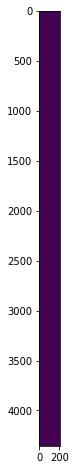

In [7]:
plt.figure(figsize=(20,8))
plt.imshow(powers_per_time[:,chan_min:chan_max], vmin = 3.e6, vmax=5.5e6)